In [6]:
import os
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.signal import periodogram

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

[utils source][1]

[1]: https://github.com/Kaggle/learntools/tree/master/learntools/time_series

In [27]:
from utils import lagplot, plot_lags, make_lags, make_leads

In [2]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

## Читаем `csv` файлы из отдельной директории

In [4]:
#Папка где у меня файлы
path = "f:\\Datasets\\kaggle-store-sales"

# ШАГ 1. Запоминаем текущую папку и меняем ее на нужную = где файл лежит
# Check current working directory.
main_path = os.getcwd()
print("Current working directory", main_path)

# Now change the directory
os.chdir( path )

# Check current working directory.
cur_path = os.getcwd()
print("Directory changed successfully",cur_path)

# ШАГ 2. Читаем файл в датафрейм df (оперативную память) для трансформации
# прочитаем файл
files = ['holidays_events', 'oil', 'sample_submission','stores', 'test', 'train', 'transactions']

dd = {}
for file in files:
    if file == 'train':
        store_sales = pd.read_csv(
            file + '.csv', #'train.csv',
            usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
            dtype={
                'store_nbr': 'category',
                'family': 'category',
                'sales': 'float32',
                'onpromotion': 'uint32',
            },
            parse_dates=['date']
        )
        store_sales['date'] = store_sales.date.dt.to_period('D')
        store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
        
        family_sales = (
            store_sales
            .groupby(['family', 'date'])
            .mean() 
            .unstack('family')
            .loc['2017', ['sales', 'onpromotion']]
        )
        # average_sales = (
        #     store_sales
        #     .groupby('date').mean()
        #     .squeeze()
        #     .loc['2017']
        # )        
        dd[file] = store_sales
        
    elif file == "holidays_events":
        holidays_events = pd.read_csv(
            file + '.csv', #"holidays_events.csv",
            dtype={
                'type': 'category',
                'locale': 'category',
                'locale_name': 'category',
                'description': 'category',
                'transferred': 'bool',
            },
            parse_dates=['date'],
        )
        holidays_events = holidays_events.set_index('date').to_period('D')
        dd[file] = holidays_events
    else:
        dd[file] = pd.read_csv(file + '.csv')
    

# ШАГ 3. Возвращаем основную рабочую директорию 
os.chdir(main_path)
cur_path = os.getcwd()
print("Directory changed successfully", cur_path)

Current working directory g:\github_projects\study-time-series-analysis\kaggle-ts
Directory changed successfully f:\Datasets\kaggle-store-sales
Directory changed successfully g:\github_projects\study-time-series-analysis\kaggle-ts


Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize Supply Sales. We'll store the result in a variable y_deseason.

In [14]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)



In [15]:
X_time.head(7)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYearsDay
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False
2017-01-06,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.848644,0.528964,0.897805,-0.440394,0.101168,-0.994869,-0.790776,-0.612106,False
2017-01-07,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.937752,0.347305,0.651372,-0.758758,-0.485302,-0.874347,-0.988468,0.151428,False


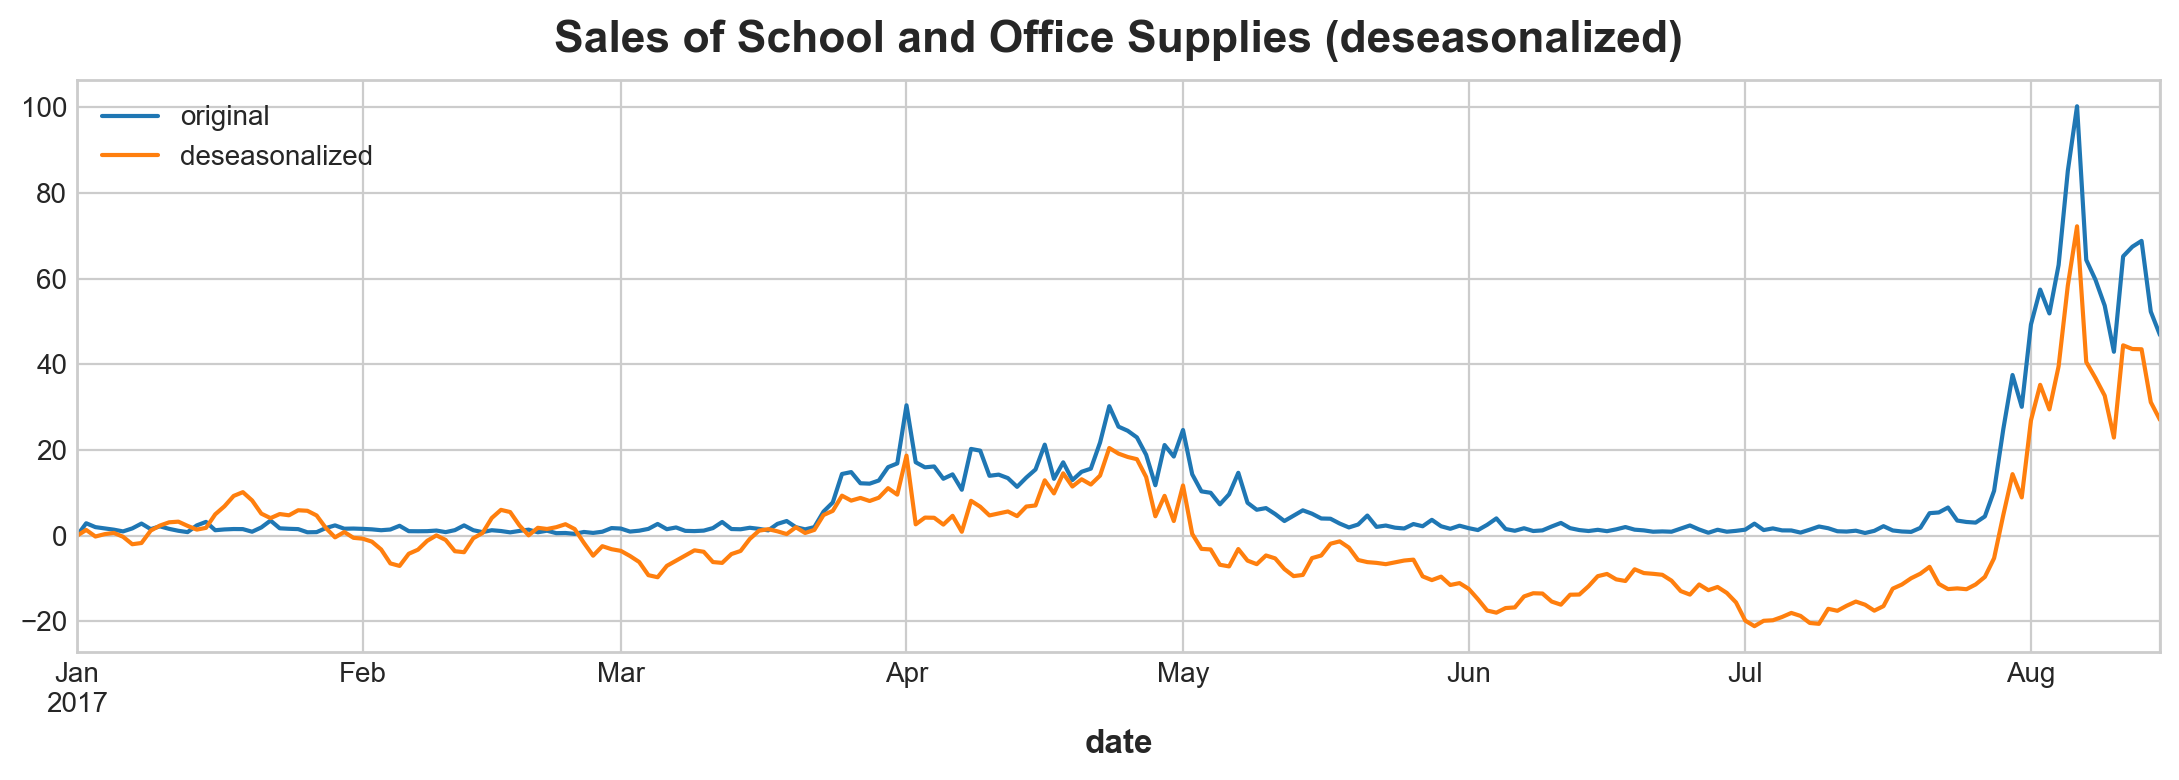

In [17]:
model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y.plot(label='original')
ax.set_title("Sales of School and Office Supplies (original)");

ax = y_deseason.plot(label='deseasonalized')
ax.set_title("Sales of School and Office Supplies (deseasonalized)");
ax.legend();

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

# 1) Plotting cycles
Create a seven-day moving average from y, the series of supply sales. Use a centered window, but don't set the min_periods argument.

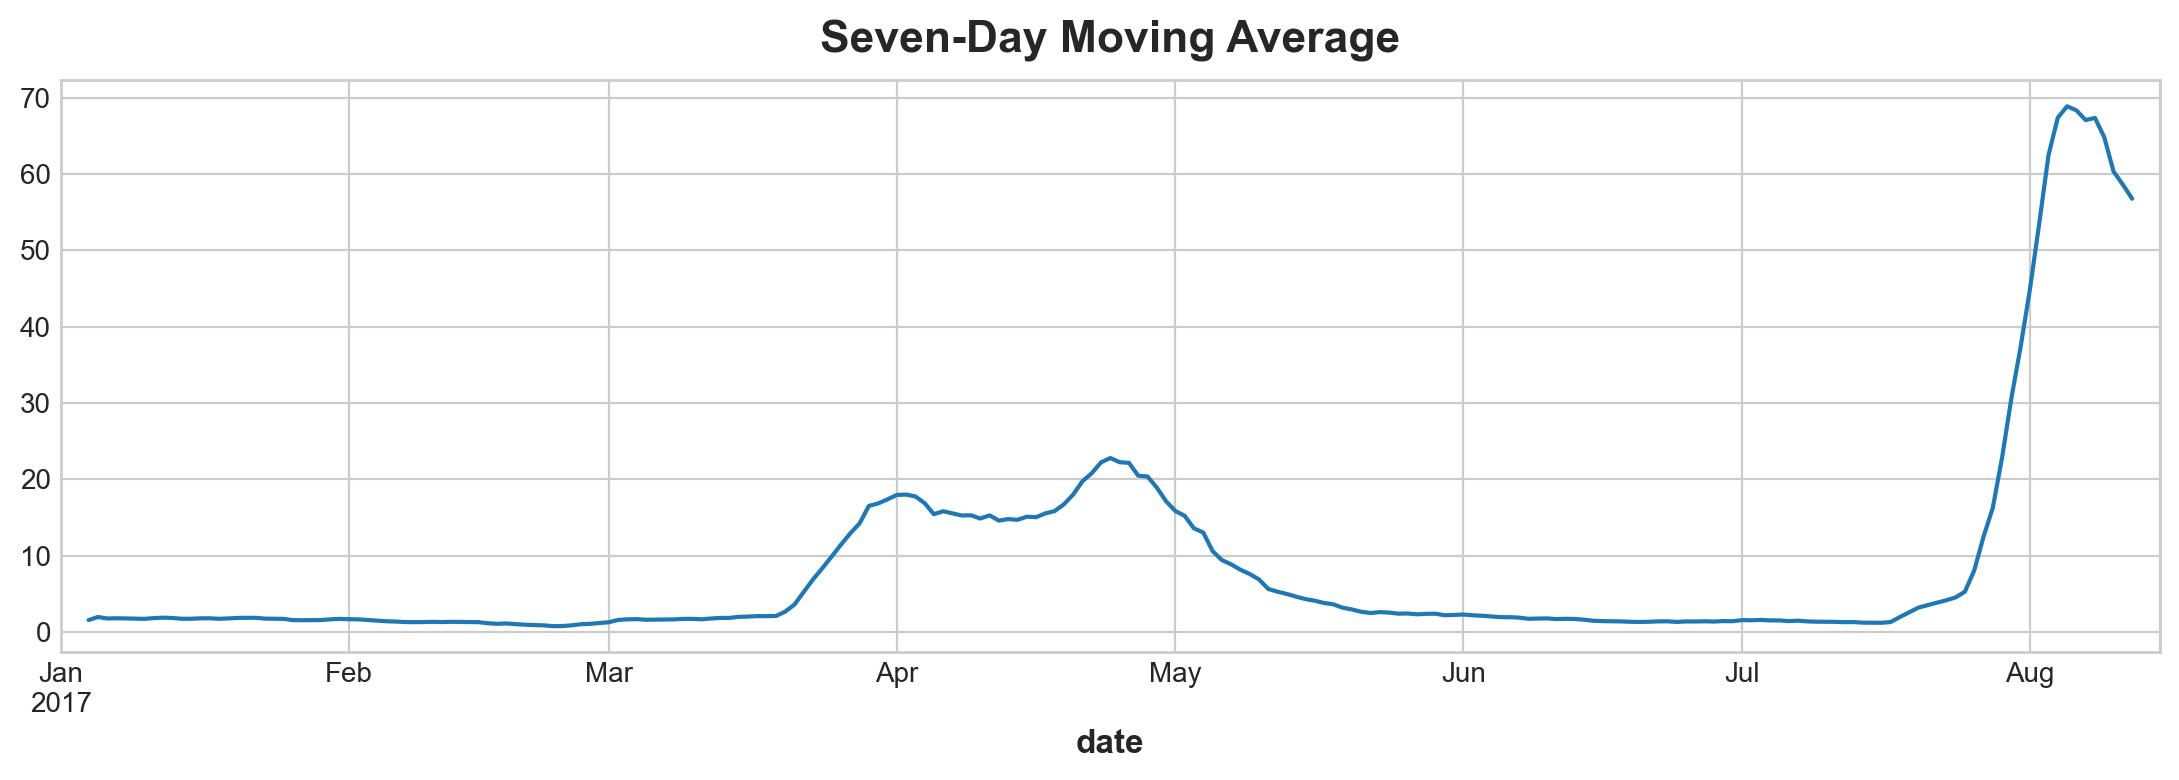

In [18]:
y_ma = y.rolling(7, center=True).mean()

# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

Do you see how the moving average plot resembles the plot of the deseasonalized series? In both, we can see cyclic behavior indicated.

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

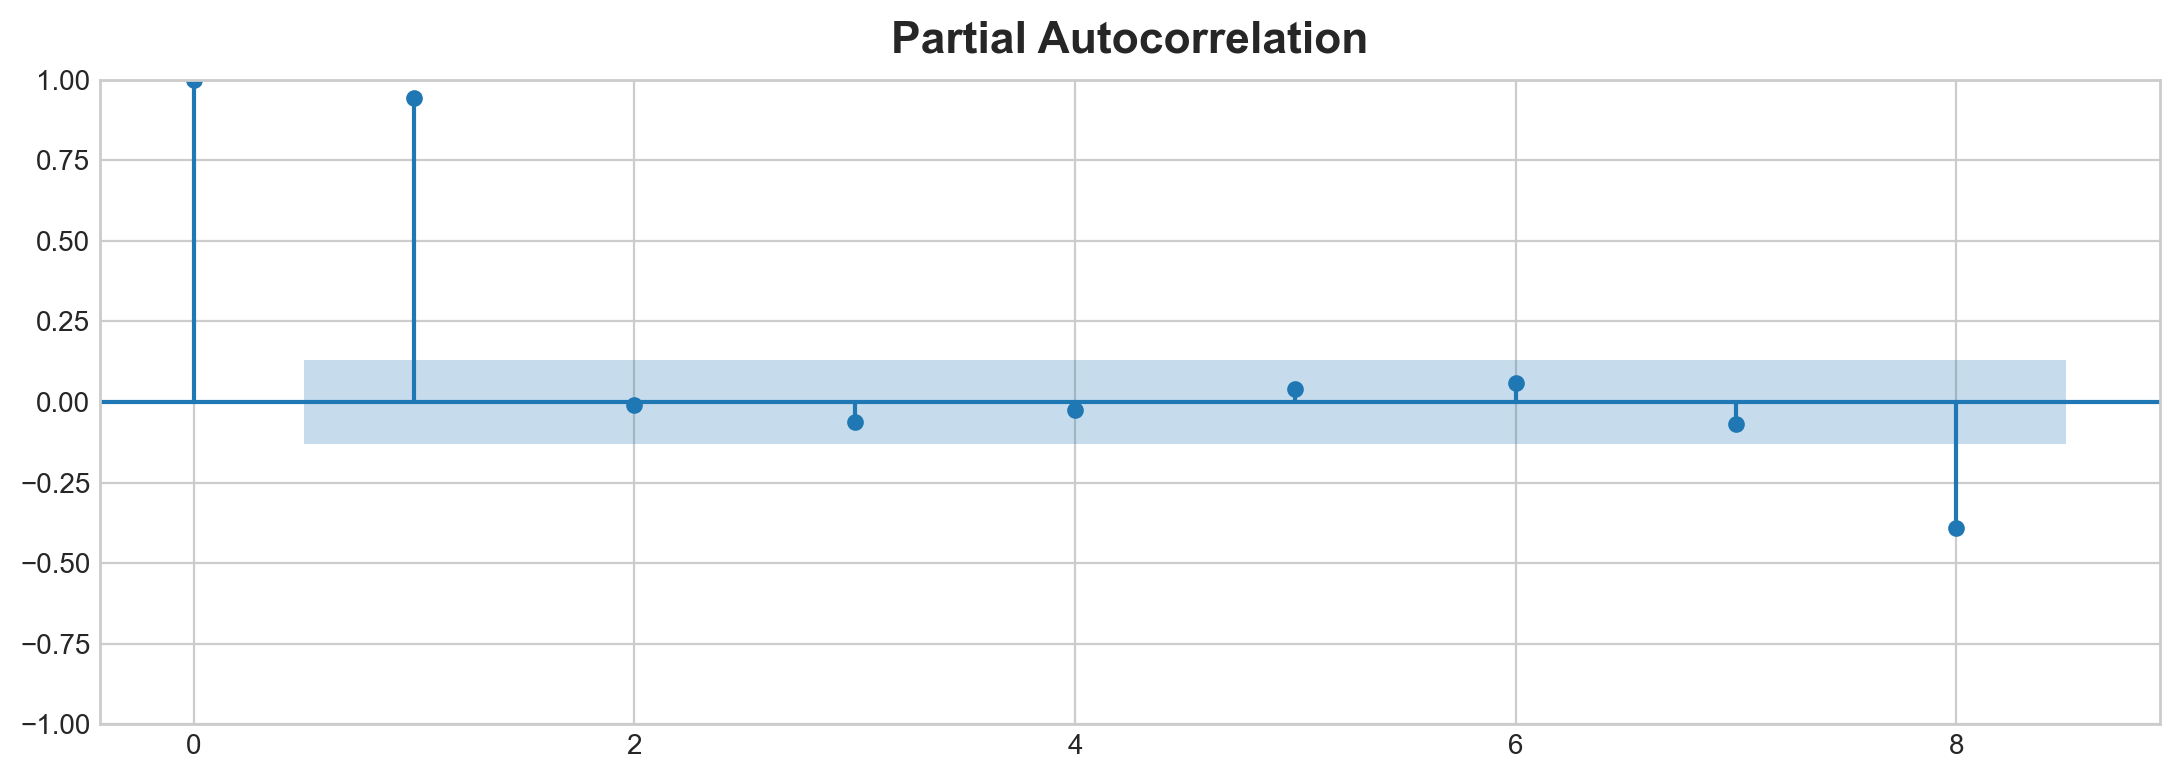

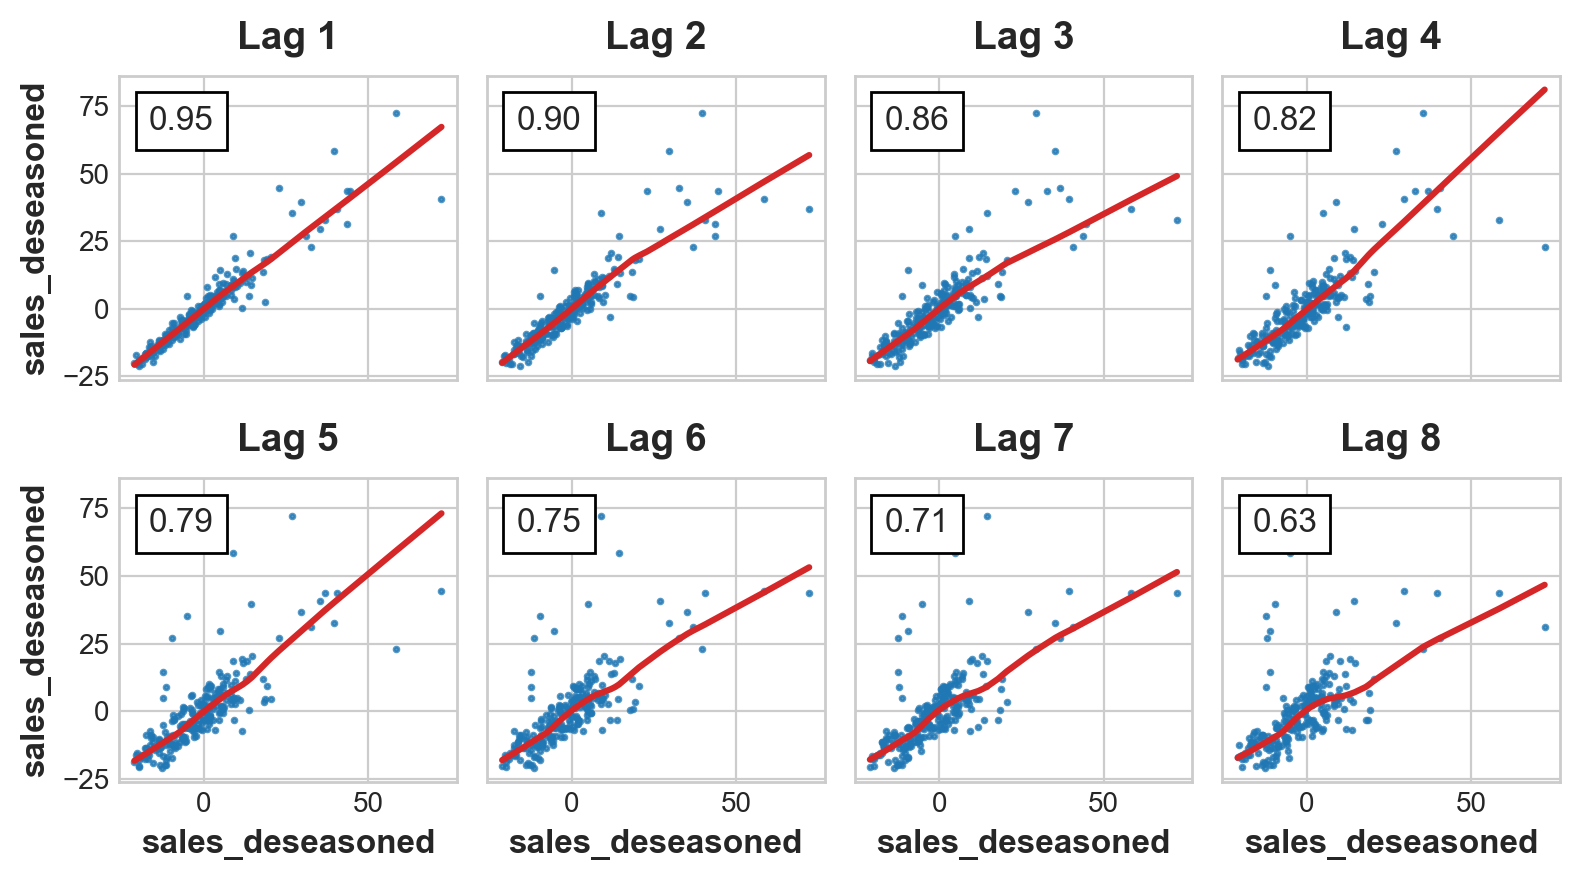

In [22]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

# 2) Examine serial dependence in Store Sales

Are any of the lags significant according to the correlogram? Does the lag plot suggest any relationships that weren't apparent from the correlogram?

answer:

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.

Recall from the tutorial that a leading indicator is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The competition dataset includes a time series that could potentially be useful as a leading indicator -- the `onpromotion` series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's `onpromotion` value to forecast sales on Monday, for instance.

Use the next cell to examine leading and lagging values for `onpromotion` plotted against sales of school and office supplies.

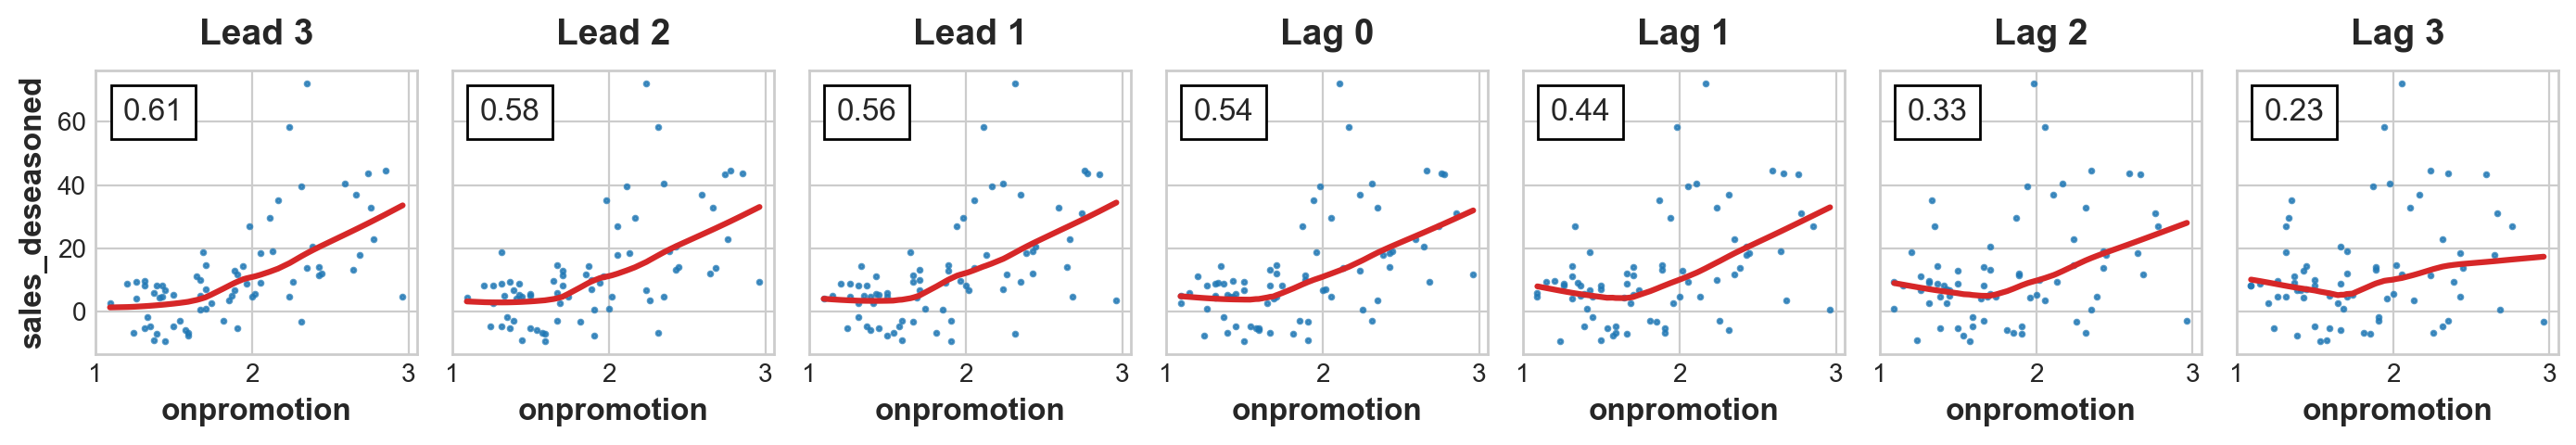

In [23]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

# 3) Examine time series features
Does it appear that either leading or lagging values of `onpromotion` could be useful as a feature?

answer: 

The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

# 4) Create time series features
Create the features indicated in the solution to Question 3. If no features from that series would be useful, use an empty dataframe pd.DataFrame() as your answer.

In [28]:
X_lags = make_lags(y_deseason, lags=1)

# YOUR CODE HERE: Make features from `onpromotion`
# You may want to use `pd.concat`
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Use the code in the next cell if you'd like to see predictions from the resulting model.

Training RMSLE: 0.83417
Validation RMSLE: 1.17316


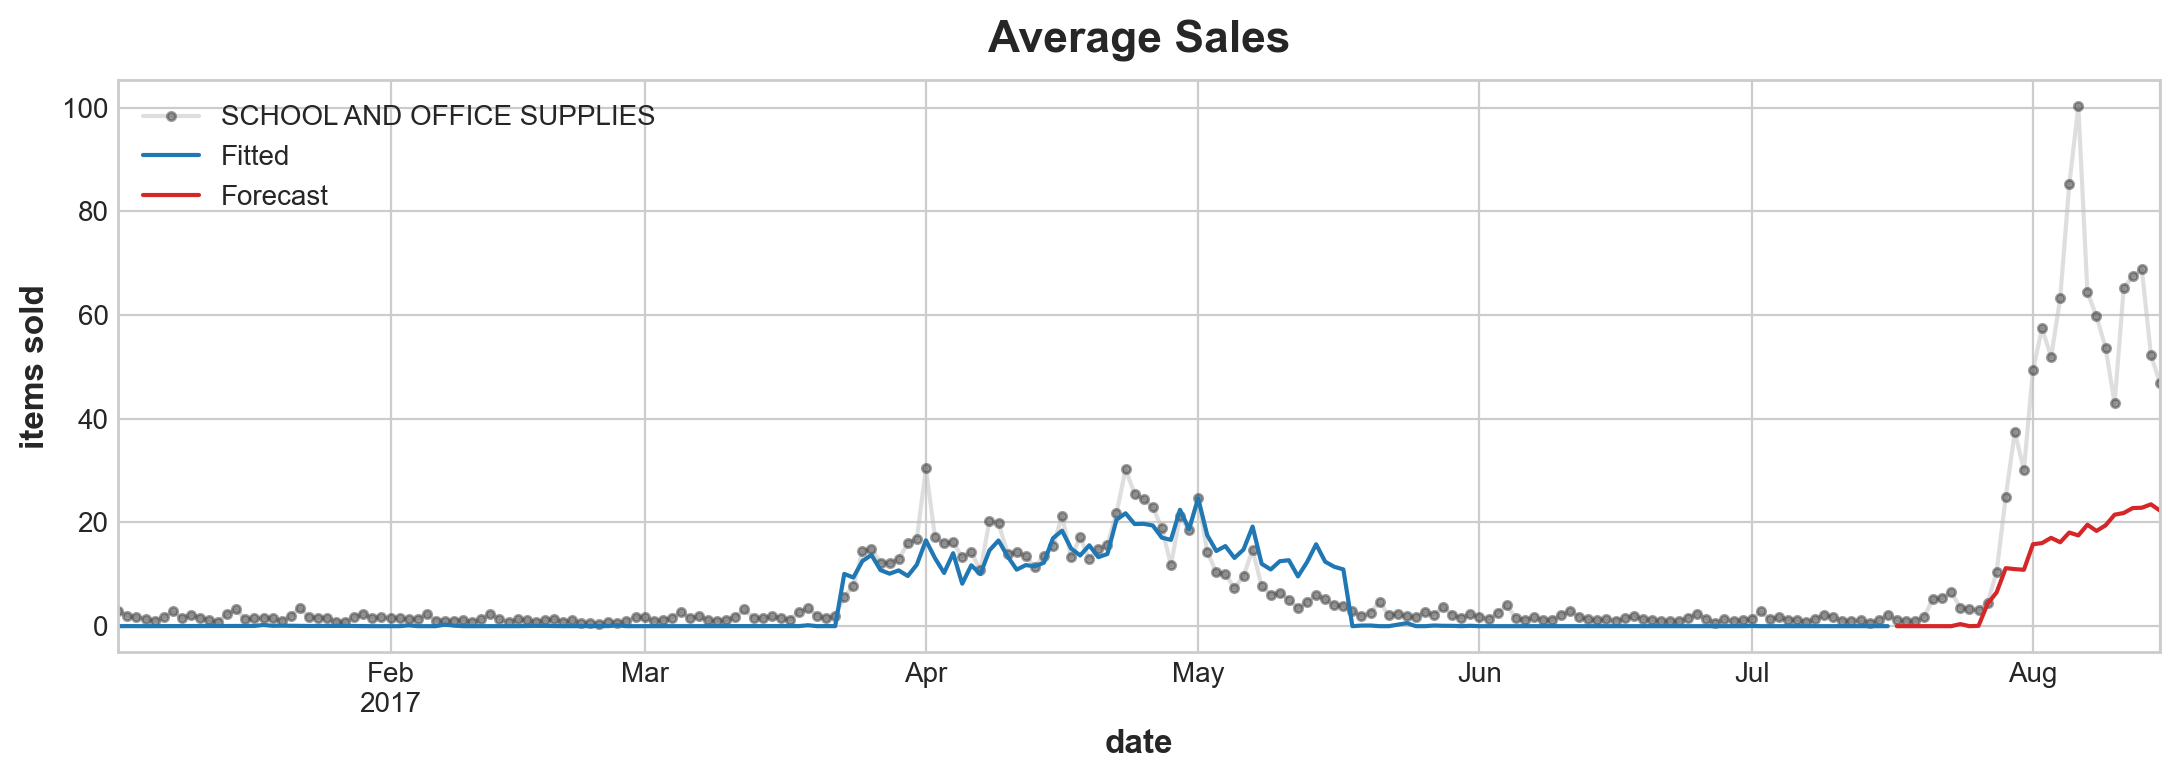

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

Winners of Kaggle forecasting competitions have often included moving averages and other rolling statistics in their feature sets. Such features seem to be especially useful when used with GBDT algorithms like XGBoost.

In Lesson 2 you learned how to compute moving averages to estimate trends. Computing rolling statistics to be used as features is similar except we need to take care to avoid lookahead leakage. First, the result should be set at the right end of the window instead of the center -- that is, we should use center=False (the default) in the rolling method. Second, the target should be lagged a step.

# 5) Create statistical features
Create the following features:

- 14-day rolling median (median) of lagged target
- 7-day rolling standard deviation (std) of lagged target
- 7-day sum (sum) of items "on promotion", with centered window

In [30]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

# 7-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# YOUR CODE HERE: 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# YOUR CODE HERE: 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# YOUR CODE HERE: 7-day sum of promotions with centered window
promo_7 = onpromo.rolling(7, center=True).sum()

**Check out the Pandas Window documentation for more statistics you can compute. Also try "exponential weighted" windows by using ewm in place of rolling; exponential decay is often a more realistic representation of how effects propagate over time.**